# Introduction

## Importing an audio file with Python

In [1]:
import wave
import pandas as pd
import numpy as np
from pydub import AudioSegment
from pydub.playback import play  # requires simpleaudio (WAV) or ffmpeg (others)

c:\Users\herie\miniconda3\envs\psc\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
training_labels = pd.read_csv("data/raw/training_label.csv")

folder = "data/raw/Training_data"
file = f"{folder}/1.wav"

In [3]:
training_labels 

nombre_archivo  clase
0            1.wav      1
1            2.wav      1
2            3.wav      1
3            4.wav      1
4            5.wav      1
..             ...    ...
126        178.wav      5
127        179.wav      5
128        180.wav      5
129        181.wav      5
130        182.wav      5

[131 rows x 2 columns]

In [4]:
# plot the normalized audio file
import matplotlib.pyplot as plt
def plot_waveform(signal, title="Waveform", xlabel="Time", ylabel="Amplitude"):
    plt.figure(figsize=(15, 5))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    

{'channels': 2, 'frame_rate': 44100, 'sample_width': 2, 'duration_ms': 225050, 'max_amplitude': 16883}


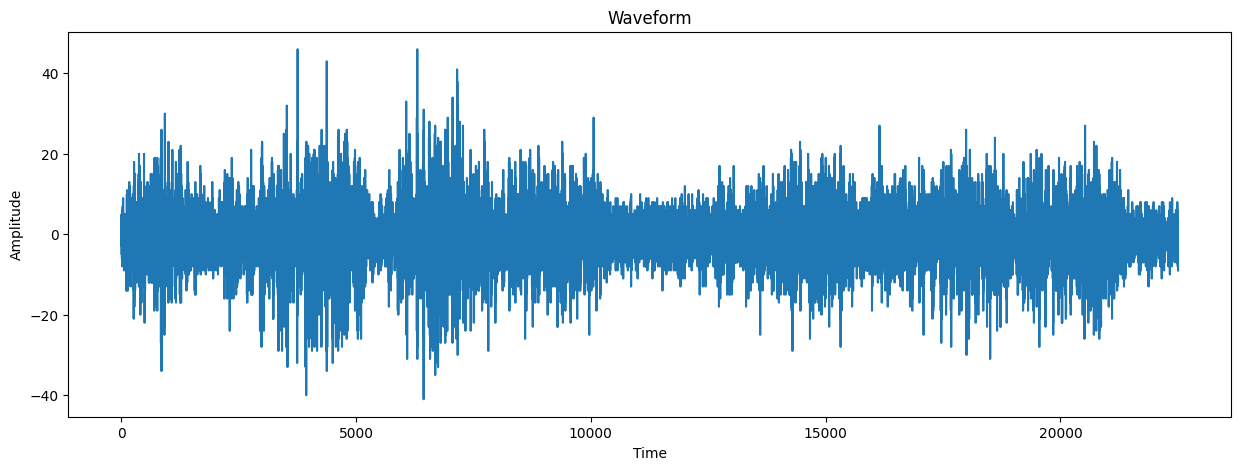

In [5]:
training_labels = pd.read_csv("data/raw/training_label.csv")

folder = "data/raw/Training_data"
file = f"{folder}/1.wav"

seg = AudioSegment.from_wav(file)  # works out of the box for WAV
# 2) Inspect core parameters
print({
    "channels": seg.channels,
    "frame_rate": seg.frame_rate,      # Hz
    "sample_width": seg.sample_width,  # bytes per sample. A byte per sample means that each sample is an integer between 0 and 255
    "duration_ms": len(seg),           # milliseconds
    "max_amplitude": seg.max           # max possible amplitude the range is 0 to (2^(8*sample_width))-1
})
# 3) Normalize to ASR-friendly PCM: mono, 16 kHz, 16-bit
target = (
    seg.set_channels(1)
       .set_frame_rate(100)
       .set_sample_width(1)  # 2 bytes = 16-bit PCM
)


plot_waveform(target.get_array_of_samples())

{'channels': 2, 'frame_rate': 44100, 'sample_width': 2, 'duration_ms': 225050, 'max_amplitude': 16883}


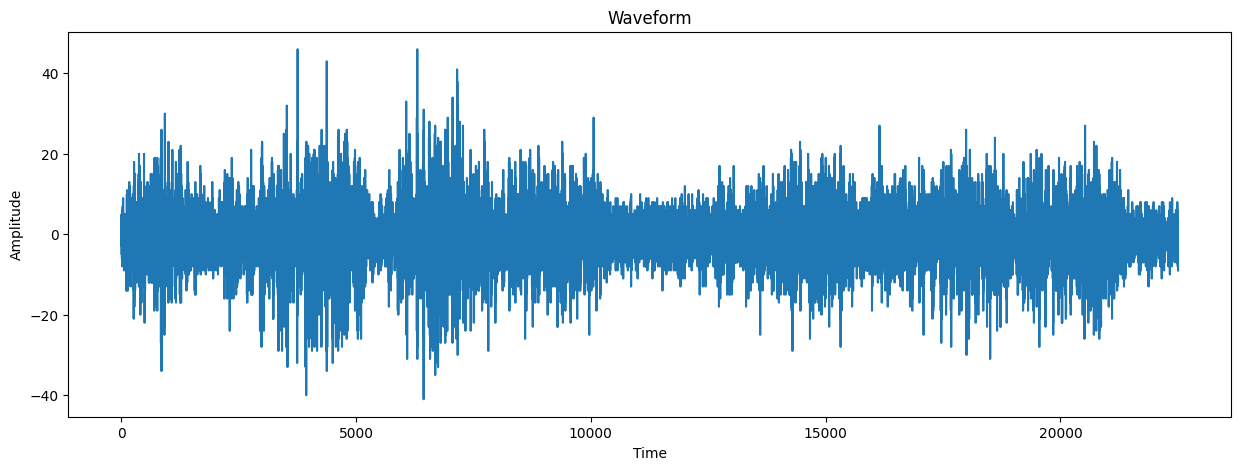

In [6]:
training_labels = pd.read_csv("data/raw/training_label.csv")

folder = "data/raw/Training_data"
file = f"{folder}/1.wav"

seg = AudioSegment.from_file(file)  # works out of the box for WAV
# 2) Inspect core parameters
print({
    "channels": seg.channels,
    "frame_rate": seg.frame_rate,      # Hz
    "sample_width": seg.sample_width,  # bytes per sample. A byte per sample means that each sample is an integer between 0 and 255
    "duration_ms": len(seg),           # milliseconds
    "max_amplitude": seg.max           # max possible amplitude the range is 0 to (2^(8*sample_width))-1
})
# 3) Normalize to ASR-friendly PCM: mono, 16 kHz, 16-bit
target = (
    seg.set_channels(1)
       .set_frame_rate(100)
       .set_sample_width(1)  # 2 bytes = 16-bit PCM
)


plot_waveform(target.get_array_of_samples())

# Plot all the audio files in a directory

C:\Users\herie\AppData\Local\Temp\ipykernel_33712\2796985231.py:116: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


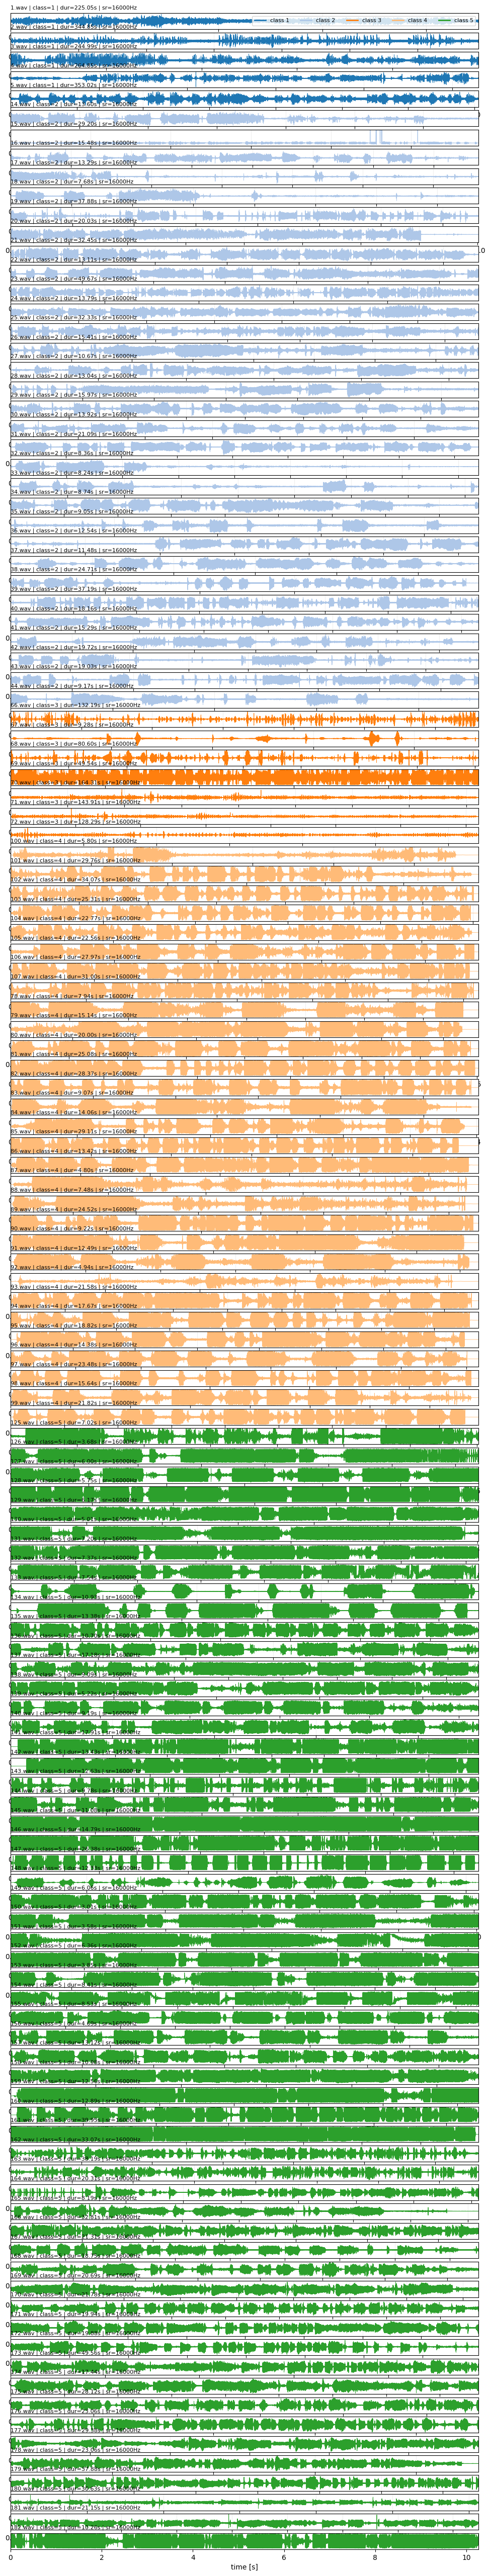

In [7]:
# %pip install -U pandas matplotlib pydub

import os, glob, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH   = "data/raw/training_label.csv"
AUDIO_DIR  = Path("data/raw/Training_data")
PATTERN    = "*.wav"
MAX_FILES  = None              # e.g. 120 to limit; None = all
TARGET_SR  = 16_000            # None = keep original; else resample with pydub
TARGET_SW  = 2                 # bytes per sample; 2 = 16-bit PCM
MAKE_MONO  = True              # force mono for consistent plots
DOWNSAMPLE = 4                 # plot every k-th point; set 1 for full resolution
SAVE_PNG   = None              # e.g. "results/all_waveforms_pydub.png"

# -----------------------------
# HELPERS
# -----------------------------
def segment_to_mono_np(seg: AudioSegment) -> tuple[np.ndarray, float]:
    """
    Convert a pydub AudioSegment to a normalized mono numpy array in [-1, 1),
    and return (y, sr). Handles sample width and sign.
    """
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR)
        sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
        sw = TARGET_SW

    arr = np.array(seg.get_array_of_samples())

    # Normalize by signed peak based on sample width
    # 8-bit: 128; 16-bit: 32768; 24-bit: 8388608; 32-bit: 2147483648
    peak = float(1 << (8 * sw - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")

if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

n = len(df)
assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# CLASS ORDER + COLORS
# -----------------------------
class_order = sorted(df["clase"].unique())        # define class order
# preserve original within-class order while grouping by class
df["idx0"] = np.arange(len(df))
df["clase"] = pd.Categorical(df["clase"], categories=class_order, ordered=True)
df = df.sort_values(["clase", "idx0"], kind="stable").drop(columns="idx0")

palette = plt.get_cmap("tab20").colors           # fixed palette
color_map = {c: palette[i % len(palette)] for i, c in enumerate(class_order)}

# -----------------------------
# PLOT
# -----------------------------
row_h = 0.5
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, fig_h), sharex=False)
if n == 1:
    axes = [axes]

for ax, (p, fname, cls) in zip(
    axes,
    df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)
):
    seg = AudioSegment.from_file(p)

    y, sr = segment_to_mono_np(seg)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr

    t = np.arange(len(y)) / sr_eff if len(y) else np.array([0.0])
    ax.plot(t, y, linewidth=0.6, color=color_map[cls])
    ax.set_title(
        f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={int(sr)}Hz",
        fontsize=8,
        loc="left"
    )
    ax.set_yticks([])
    ax.grid(True, alpha=0.2)
    ax.set_xlim(0, t[-1] if len(t) else 0)

axes[-1].set_xlabel("time [s]")
legend_elems = [Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in class_order]
axes[0].legend(handles=legend_elems, ncols=min(len(class_order), 6), fontsize=8, loc="upper right", frameon=True)

plt.tight_layout()
if SAVE_PNG:
    Path(SAVE_PNG).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(SAVE_PNG, dpi=200)
plt.show()


# Plot furier

C:\Users\herie\AppData\Local\Temp\ipykernel_33712\2694467071.py:145: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


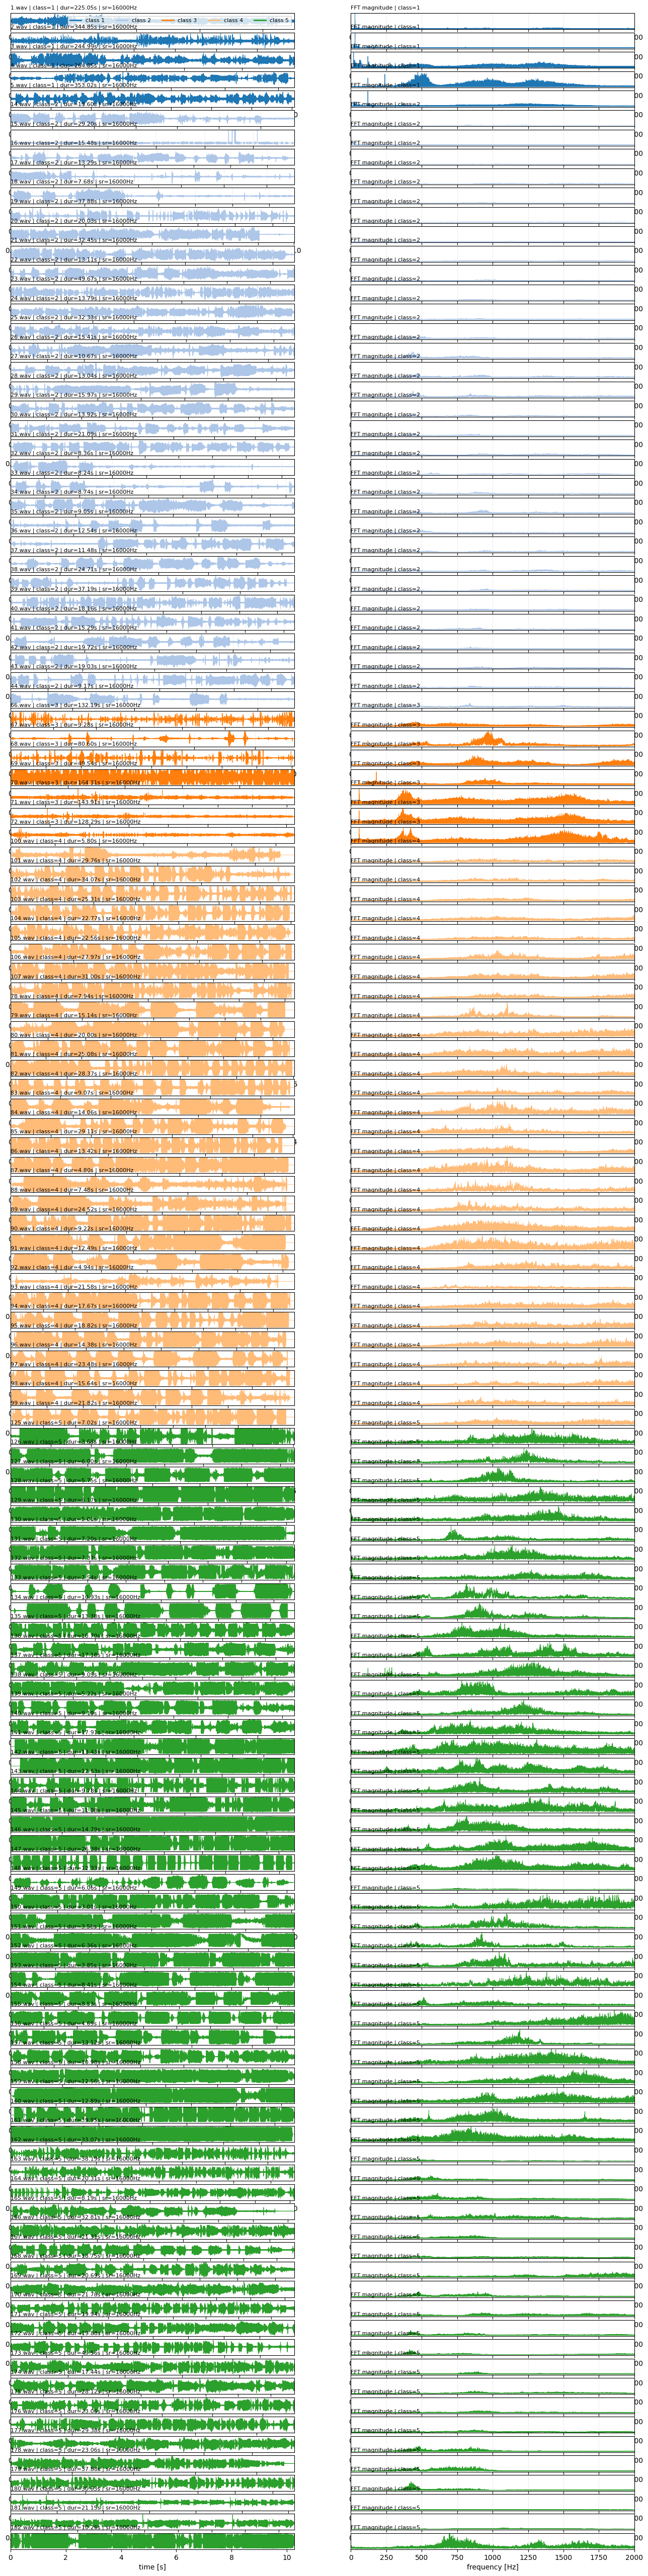

In [8]:
# %pip install -U pandas matplotlib pydub

import os, glob, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH   = "data/raw/training_label.csv"
AUDIO_DIR  = Path("data/raw/Training_data")
PATTERN    = "*.wav"
MAX_FILES  = None              # e.g. 120 to limit; None = all
TARGET_SR  = 16_000            # None = keep original; else resample with pydub
TARGET_SW  = 2                 # bytes per sample; 2 = 16-bit PCM
MAKE_MONO  = True              # force mono for consistent plots
DOWNSAMPLE = 4                 # plot every k-th point; set 1 for full resolution
SAVE_PNG   = None              # e.g. "results/all_waveforms_and_fft.png"

# -----------------------------
# HELPERS
# -----------------------------
def segment_to_mono_np(seg: AudioSegment) -> tuple[np.ndarray, float]:
    """
    Convert a pydub AudioSegment to a normalized mono numpy array in [-1, 1),
    and return (y, sr). Handles sample width and sign.
    """
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR)
        sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
        sw = TARGET_SW

    arr = np.array(seg.get_array_of_samples())

    # Normalize by signed peak based on sample width
    # 8-bit: 128; 16-bit: 32768; 24-bit: 8388608; 32-bit: 2147483648
    peak = float(1 << (8 * sw - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")

if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

n = len(df)
assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# CLASS ORDER + COLORS
# -----------------------------
class_order = sorted(df["clase"].unique())        # define class order
df["idx0"] = np.arange(len(df))                   # preserve original within-class order
df["clase"] = pd.Categorical(df["clase"], categories=class_order, ordered=True)
df = df.sort_values(["clase", "idx0"], kind="stable").drop(columns="idx0")

palette = plt.get_cmap("tab20").colors            # fixed palette
color_map = {c: palette[i % len(palette)] for i, c in enumerate(class_order)}

# -----------------------------
# PLOT: waveform (left) + FFT magnitude (right)
# -----------------------------
row_h = 0.5
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(16, fig_h), sharex=False)
if n == 1:
    # normalize shape to (1, 2)
    axes = np.array([axes])

for i, (p, fname, cls) in enumerate(df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)):
    left_ax, right_ax = axes[i]

    seg = AudioSegment.from_file(p)
    y, sr = segment_to_mono_np(seg)

    # Optional time downsampling for plotting (applies to FFT too for consistency)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr

    # ---- Time-domain plot (left) ----
    if len(y):
        t = np.arange(len(y)) / sr_eff
    else:
        t = np.array([0.0])

    left_ax.plot(t, y, linewidth=0.6, color=color_map[cls])
    left_ax.set_title(f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={int(sr)}Hz",
                      fontsize=8, loc="left")
    left_ax.set_yticks([])
    left_ax.grid(True, alpha=0.2)
    left_ax.set_xlim(0, t[-1] if len(t) else 0)

    # ---- Frequency-domain plot (right) ----
    if len(y) > 0:
        # Use rFFT for real signals
        Y = np.fft.rfft(y)
        freqs = np.fft.rfftfreq(len(y), d=1.0 / sr_eff)
        mag = np.abs(Y)

        right_ax.plot(freqs, mag, linewidth=0.6, color=color_map[cls])
        right_ax.set_xlim(0, sr_eff / 2.0)
    else:
        freqs = np.array([0.0])
        mag = np.array([0.0])
        right_ax.plot(freqs, mag, linewidth=0.6, color=color_map[cls])
        right_ax.set_xlim(0, 1.0)

    right_ax.set_title(f"FFT magnitude | class={cls}", fontsize=8, loc="left")
    right_ax.set_yticks([])
    right_ax.grid(True, alpha=0.2)

# Axis labels on bottom row only
axes[-1, 0].set_xlabel("time [s]")
axes[-1, 1].set_xlabel("frequency [Hz]")

# Legend on the top-left subplot
legend_elems = [Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in class_order]
axes[0, 0].legend(handles=legend_elems,
                  ncols=min(len(class_order), 6),
                  fontsize=8,
                  loc="upper right",
                  frameon=True)

plt.tight_layout()
if SAVE_PNG:
    Path(SAVE_PNG).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(SAVE_PNG, dpi=200)
plt.show()


# Plot Fourier TEST

In [3]:
# count how many files in this folder
AUDIO_DIR  = Path("data/raw/Testing_data")
len(list(AUDIO_DIR.glob("*.wav")))

40

c:\Users\herie\miniconda3\envs\psc\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\herie\AppData\Local\Temp\ipykernel_35388\666161731.py:145: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


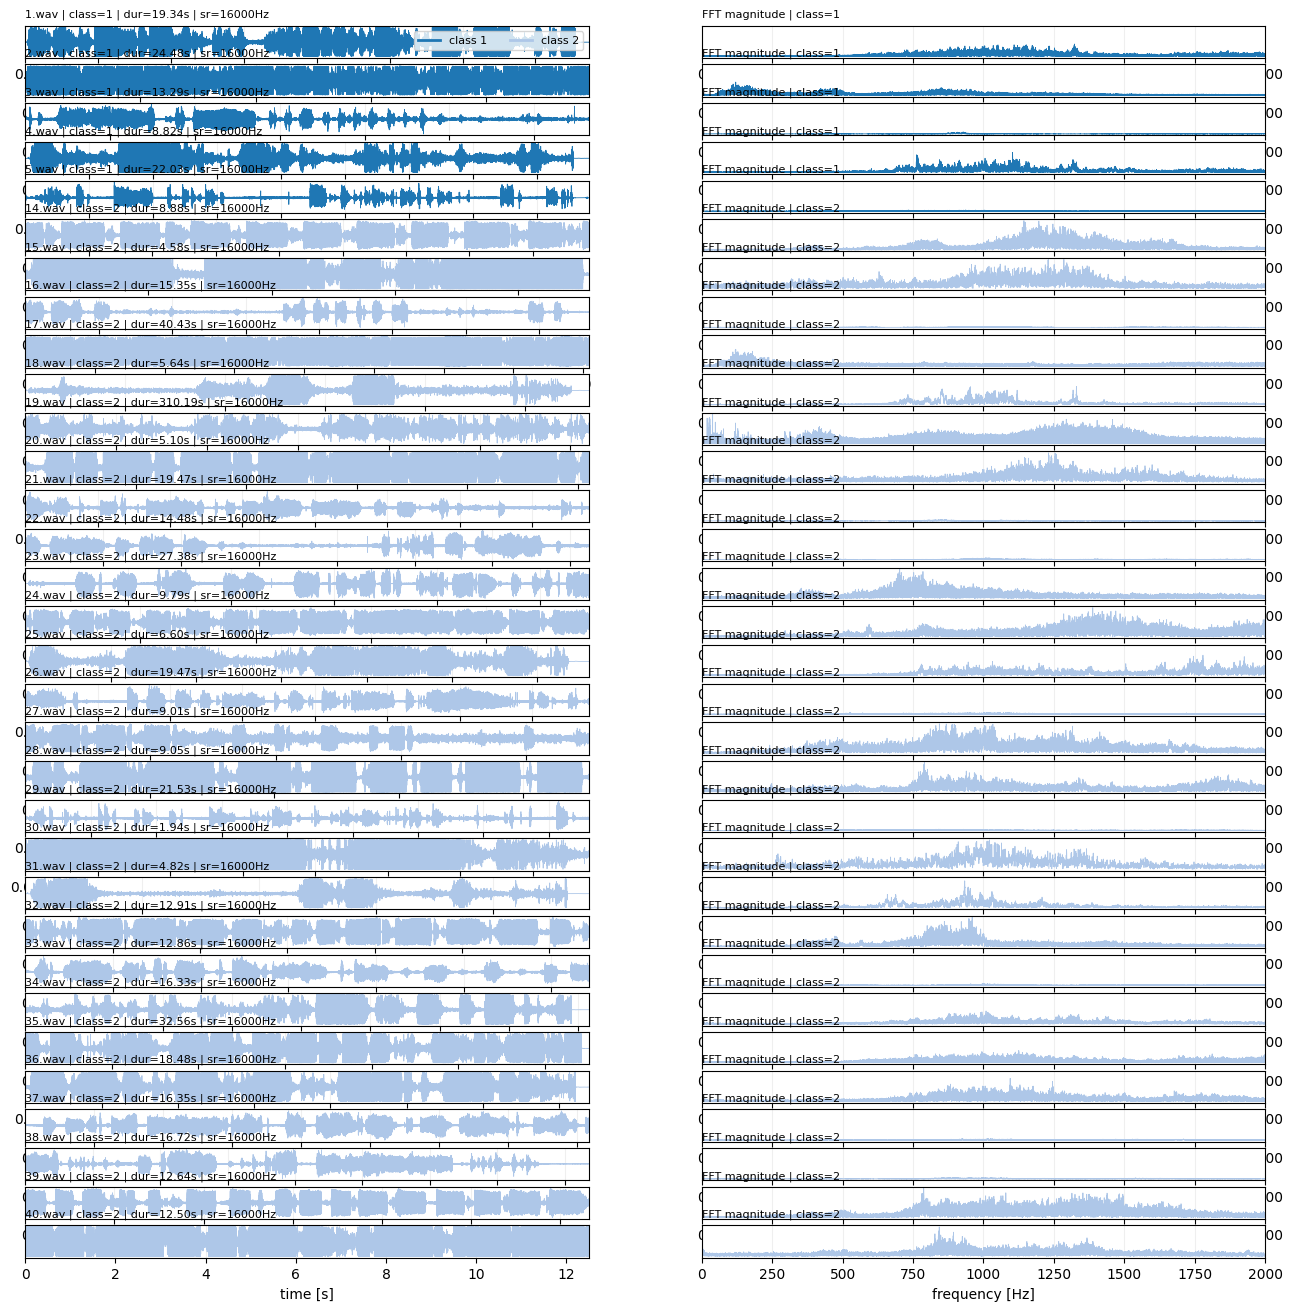

In [1]:
# %pip install -U pandas matplotlib pydub

import os, glob, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH   = "data/raw/training_label.csv"
AUDIO_DIR  = Path("data/raw/Testing_data")
PATTERN    = "*.wav"
MAX_FILES  = None              # e.g. 120 to limit; None = all
TARGET_SR  = 16_000            # None = keep original; else resample with pydub
TARGET_SW  = 2                 # bytes per sample; 2 = 16-bit PCM
MAKE_MONO  = True              # force mono for consistent plots
DOWNSAMPLE = 4                 # plot every k-th point; set 1 for full resolution
SAVE_PNG   = None              # e.g. "results/all_waveforms_and_fft.png"

# -----------------------------
# HELPERS
# -----------------------------
def segment_to_mono_np(seg: AudioSegment) -> tuple[np.ndarray, float]:
    """
    Convert a pydub AudioSegment to a normalized mono numpy array in [-1, 1),
    and return (y, sr). Handles sample width and sign.
    """
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR)
        sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
        sw = TARGET_SW

    arr = np.array(seg.get_array_of_samples())

    # Normalize by signed peak based on sample width
    # 8-bit: 128; 16-bit: 32768; 24-bit: 8388608; 32-bit: 2147483648
    peak = float(1 << (8 * sw - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")

if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

n = len(df)
assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# CLASS ORDER + COLORS
# -----------------------------
class_order = sorted(df["clase"].unique())        # define class order
df["idx0"] = np.arange(len(df))                   # preserve original within-class order
df["clase"] = pd.Categorical(df["clase"], categories=class_order, ordered=True)
df = df.sort_values(["clase", "idx0"], kind="stable").drop(columns="idx0")

palette = plt.get_cmap("tab20").colors            # fixed palette
color_map = {c: palette[i % len(palette)] for i, c in enumerate(class_order)}

# -----------------------------
# PLOT: waveform (left) + FFT magnitude (right)
# -----------------------------
row_h = 0.5
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(16, fig_h), sharex=False)
if n == 1:
    # normalize shape to (1, 2)
    axes = np.array([axes])

for i, (p, fname, cls) in enumerate(df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)):
    left_ax, right_ax = axes[i]

    seg = AudioSegment.from_file(p)
    y, sr = segment_to_mono_np(seg)

    # Optional time downsampling for plotting (applies to FFT too for consistency)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr

    # ---- Time-domain plot (left) ----
    if len(y):
        t = np.arange(len(y)) / sr_eff
    else:
        t = np.array([0.0])

    left_ax.plot(t, y, linewidth=0.6, color=color_map[cls])
    left_ax.set_title(f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={int(sr)}Hz",
                      fontsize=8, loc="left")
    left_ax.set_yticks([])
    left_ax.grid(True, alpha=0.2)
    left_ax.set_xlim(0, t[-1] if len(t) else 0)

    # ---- Frequency-domain plot (right) ----
    if len(y) > 0:
        # Use rFFT for real signals
        Y = np.fft.rfft(y)
        freqs = np.fft.rfftfreq(len(y), d=1.0 / sr_eff)
        mag = np.abs(Y)

        right_ax.plot(freqs, mag, linewidth=0.6, color=color_map[cls])
        right_ax.set_xlim(0, sr_eff / 2.0)
    else:
        freqs = np.array([0.0])
        mag = np.array([0.0])
        right_ax.plot(freqs, mag, linewidth=0.6, color=color_map[cls])
        right_ax.set_xlim(0, 1.0)

    right_ax.set_title(f"FFT magnitude | class={cls}", fontsize=8, loc="left")
    right_ax.set_yticks([])
    right_ax.grid(True, alpha=0.2)

# Axis labels on bottom row only
axes[-1, 0].set_xlabel("time [s]")
axes[-1, 1].set_xlabel("frequency [Hz]")

# Legend on the top-left subplot
legend_elems = [Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in class_order]
axes[0, 0].legend(handles=legend_elems,
                  ncols=min(len(class_order), 6),
                  fontsize=8,
                  loc="upper right",
                  frameon=True)

plt.tight_layout()
if SAVE_PNG:
    Path(SAVE_PNG).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(SAVE_PNG, dpi=200)
plt.show()


In [ ]:
# %pip install -U pandas matplotlib pydub

import os, glob, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment

# -----------------------------
# CONFIG
# -----------------------------

AUDIO_DIR  = Path("data/raw/Testing_data")
PATTERN    = "*.wav"
MAX_FILES  = None              # e.g. 120 to limit; None = all
TARGET_SR  = 16_000            # None = keep original; else resample with pydub
TARGET_SW  = 2                 # bytes per sample; 2 = 16-bit PCM
MAKE_MONO  = True              # force mono for consistent plots
DOWNSAMPLE = 4                 # plot every k-th point; set 1 for full resolution
SAVE_PNG   = None              # e.g. "results/all_waveforms_and_fft.png"

# -----------------------------
# HELPERS
# -----------------------------
def segment_to_mono_np(seg: AudioSegment) -> tuple[np.ndarray, float]:
    """
    Convert a pydub AudioSegment to a normalized mono numpy array in [-1, 1),
    and return (y, sr). Handles sample width and sign.
    """
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR)
        sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
        sw = TARGET_SW

    arr = np.array(seg.get_array_of_samples())

    # Normalize by signed peak based on sample width
    # 8-bit: 128; 16-bit: 32768; 24-bit: 8388608; 32-bit: 2147483648
    peak = float(1 << (8 * sw - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")

if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

n = len(df)
assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# CLASS ORDER + COLORS
# -----------------------------
class_order = sorted(df["clase"].unique())        # define class order
df["idx0"] = np.arange(len(df))                   # preserve original within-class order
df["clase"] = pd.Categorical(df["clase"], categories=class_order, ordered=True)
df = df.sort_values(["clase", "idx0"], kind="stable").drop(columns="idx0")

palette = plt.get_cmap("tab20").colors            # fixed palette
color_map = {c: palette[i % len(palette)] for i, c in enumerate(class_order)}

# -----------------------------
# PLOT: waveform (left) + FFT magnitude (right)
# -----------------------------
row_h = 0.5
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(16, fig_h), sharex=False)
if n == 1:
    # normalize shape to (1, 2)
    axes = np.array([axes])

for i, (p, fname, cls) in enumerate(df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)):
    left_ax, right_ax = axes[i]

    seg = AudioSegment.from_file(p)
    y, sr = segment_to_mono_np(seg)

    # Optional time downsampling for plotting (applies to FFT too for consistency)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr

    # ---- Time-domain plot (left) ----
    if len(y):
        t = np.arange(len(y)) / sr_eff
    else:
        t = np.array([0.0])

    left_ax.plot(t, y, linewidth=0.6, color=color_map[cls])
    left_ax.set_title(f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={int(sr)}Hz",
                      fontsize=8, loc="left")
    left_ax.set_yticks([])
    left_ax.grid(True, alpha=0.2)
    left_ax.set_xlim(0, t[-1] if len(t) else 0)

    # ---- Frequency-domain plot (right) ----
    if len(y) > 0:
        # Use rFFT for real signals
        Y = np.fft.rfft(y)
        freqs = np.fft.rfftfreq(len(y), d=1.0 / sr_eff)
        mag = np.abs(Y)

        right_ax.plot(freqs, mag, linewidth=0.6, color=color_map[cls])
        right_ax.set_xlim(0, sr_eff / 2.0)
    else:
        freqs = np.array([0.0])
        mag = np.array([0.0])
        right_ax.plot(freqs, mag, linewidth=0.6, color=color_map[cls])
        right_ax.set_xlim(0, 1.0)

    right_ax.set_title(f"FFT magnitude | class={cls}", fontsize=8, loc="left")
    right_ax.set_yticks([])
    right_ax.grid(True, alpha=0.2)

# Axis labels on bottom row only
axes[-1, 0].set_xlabel("time [s]")
axes[-1, 1].set_xlabel("frequency [Hz]")

# Legend on the top-left subplot
legend_elems = [Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in class_order]
axes[0, 0].legend(handles=legend_elems,
                  ncols=min(len(class_order), 6),
                  fontsize=8,
                  loc="upper right",
                  frameon=True)

plt.tight_layout()
SAVE_PNG = FALSE
if SAVE_PNG:
    Path(SAVE_PNG).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(SAVE_PNG, dpi=200)
plt.show()


# Get Metrics

In [11]:
# %pip install -U pandas pydub

import glob
from pathlib import Path
import numpy as np
import pandas as pd
from pydub import AudioSegment

# =============================
# CONFIG
# =============================
CSV_PATH    = "data/raw/training_label.csv"
AUDIO_DIR   = Path("data/raw/Training_data")
PATTERN     = "*.wav"
MAX_FILES   = None
TARGET_SR   = 16_000
TARGET_SW   = 2
MAKE_MONO   = True
DOWNSAMPLE  = 4           # 1 = full res
WINDOW_SEC  = 0.50
HOP_SEC     = 0.25
CSV_METRICS = None        # e.g. "results/window_metrics.csv"

# =============================
# HELPERS
# =============================
def segment_to_mono_np(seg: AudioSegment):
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR); sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
    arr = np.array(seg.get_array_of_samples())
    peak = float(1 << (8 * seg.sample_width - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

def frame_signal(y, sr, win_s, hop_s):
    n = len(y)
    win = max(1, int(round(win_s * sr)))
    hop = max(1, int(round(hop_s * sr)))
    if n == 0: return
    i = 0
    while True:
        j = min(i + win, n)
        yield i, j, y[i:j], win   # include nominal window length
        if j >= n: break
        i += hop

def zero_cross_rate(x):
    if len(x) < 2: return 0.0
    return np.mean(np.abs(np.diff(np.signbit(x)).astype(np.float32)))

def crest_factor(x, eps=1e-12):
    if len(x) == 0: return 0.0
    return (np.max(np.abs(x)) + eps) / (np.sqrt(np.mean(x*x) + eps))

def percentiles(x, qs=(1,10,25,50,75,90,99)):
    if len(x) == 0: return {f"amp_p{q}": np.nan for q in qs}
    vals = np.percentile(x, qs)
    return {f"amp_p{q}": v for q, v in zip(qs, vals)}

def temporal_entropy(x, bins=64, eps=1e-12):
    if len(x) == 0: return np.nan
    h, _ = np.histogram(x, bins=bins, range=(-1,1), density=False)
    p = h.astype(np.float64); s = p.sum()
    if s <= 0: return 0.0
    p = p / s
    return -np.sum(p * np.log2(p + eps))

def energy_entropy(x, K=10, eps=1e-12):
    n = len(x)
    if n == 0: return np.nan
    splits = np.array_split(x, K)
    e = np.array([np.sum(si*si) for si in splits], dtype=np.float64)
    if e.sum() == 0: return 0.0
    p = e / (e.sum() + eps)
    return -np.sum(p * np.log2(p + eps))

def spectral_features(mag, freqs, eps=1e-18):
    P = (mag ** 2).astype(np.float64)
    S = P.sum()
    if S <= 0:
        keys = [
            "spec_centroid","spec_spread","spec_skew","spec_kurt",
            "spec_rolloff85","spec_rolloff95","spec_flatness","spec_slope",
            "spec_decrease","spec_crest","spec_entropy","f_peak","peak_prominence",
            "band_0_250","band_250_500","band_500_1000","band_1000_2000","band_2000_4000","band_4000_8000"
        ]
        return {k: np.nan for k in keys}
    w = P / (S + eps)
    mu = np.sum(freqs * w)
    spread = np.sqrt(np.sum(((freqs - mu) ** 2) * w))
    skew = np.sum(((freqs - mu) ** 3) * w) / (spread**3 + eps)
    kurt = np.sum(((freqs - mu) ** 4) * w) / (spread**4 + eps)
    csum = np.cumsum(P)
    def rolloff(q):
        idx = np.searchsorted(csum, q * S, side="left")
        idx = min(idx, len(freqs)-1)
        return freqs[idx]
    r85 = rolloff(0.85); r95 = rolloff(0.95)
    flat = np.exp(np.mean(np.log(P + eps))) / (np.mean(P) + eps)
    x = freqs; y = mag
    xmean = x.mean(); ymean = y.mean()
    slope = np.sum((x - xmean) * (y - ymean)) / (np.sum((x - xmean)**2) + eps)
    k = np.arange(1, len(mag))
    decrease = np.sum((mag[1:] - mag[0]) / k) / (np.sum(np.abs(mag[1:])) + eps)
    w_nonzero = w[w > 0]
    spec_ent = -np.sum(w_nonzero * np.log2(w_nonzero))
    crest = (np.max(P) + eps) / (np.mean(P) + eps)
    i_peak = int(np.argmax(P))
    f_peak = freqs[i_peak]
    if len(P) > 2:
        i2 = np.argpartition(P, -2)[-2:]
        p_sorted = np.sort(P[i2])
        prom = p_sorted[-1] / (p_sorted[-2] + eps) if len(p_sorted) == 2 else np.nan
    else:
        prom = np.nan
    bands = [(0,250),(250,500),(500,1000),(1000,2000),(2000,4000),(4000,8000)]
    band_feats = {}
    for lo, hi in bands:
        m = (freqs >= lo) & (freqs < hi)
        band_feats[f"band_{lo}_{hi}"] = P[m].sum() / (S + eps)
    return {
        "spec_centroid": mu,
        "spec_spread": spread,
        "spec_skew": skew,
        "spec_kurt": kurt,
        "spec_rolloff85": r85,
        "spec_rolloff95": r95,
        "spec_flatness": flat,
        "spec_slope": slope,
        "spec_decrease": decrease,
        "spec_crest": crest,
        "spec_entropy": spec_ent,
        "f_peak": f_peak,
        "peak_prominence": prom,
        **band_feats
    }

def spectral_flux(curr_mag, prev_mag):
    if prev_mag is None: return np.nan
    eps = 1e-12
    a = curr_mag / (np.linalg.norm(curr_mag) + eps)
    b = prev_mag / (np.linalg.norm(prev_mag) + eps)
    return np.sqrt(np.sum((a - b)**2))

def pitch_autocorr(frame, sr, fmin=50.0, fmax=500.0):
    n = len(frame)
    if n < 3: return np.nan, np.nan
    x = frame - np.mean(frame)
    if np.allclose(x, 0.0): return np.nan, np.nan
    lag_min = int(sr / fmax)
    lag_max = min(int(sr / fmin), n-1)
    if lag_max <= lag_min: return np.nan, np.nan
    acf = np.array([np.dot(x[:-lag], x[lag:]) for lag in range(lag_min, lag_max+1)], dtype=np.float64)
    lag_hat = lag_min + int(np.argmax(acf))
    f0 = sr / lag_hat if lag_hat > 0 else np.nan
    hr = acf.max() / (np.dot(x, x) + 1e-12)
    return f0, hr

def next_pow2(n):
    n = max(1, int(n))
    return 1 << (int(np.ceil(np.log2(n))))

def window_metrics_for_signal(y, sr, win_s, hop_s, cls, fname):
    rows = []
    prev_mag = None
    win_n = max(1, int(round(win_s * sr)))
    n_fft = next_pow2(win_n)          # constant FFT size per signal
    freqs_const = np.fft.rfftfreq(n_fft, d=1.0/sr)
    for w_idx, (i, j, x, win_nom) in enumerate(frame_signal(y, sr, win_s, hop_s)):
        t0 = i / sr; t1 = j / sr
        # time features
        rms = np.sqrt(np.mean(x*x)) if len(x) else 0.0
        zcr = zero_cross_rate(x)
        cf  = crest_factor(x)
        ptp = np.ptp(x) if len(x) else 0.0
        var = float(np.var(x)) if len(x) else 0.0
        skw = (pd.Series(x).skew() if len(x) > 2 else np.nan)
        kur = (pd.Series(x).kurt() if len(x) > 3 else np.nan)
        ent_t = temporal_entropy(x)
        ent_e = energy_entropy(x)
        pct  = percentiles(x)
        # spectrum with fixed n_fft
        if len(x) > 0:
            Y = np.fft.rfft(x, n=n_fft)
            mag = np.abs(Y)
            spec = spectral_features(mag, freqs_const)
            spec["spec_flux"] = spectral_flux(mag, prev_mag)
            prev_mag = mag
        else:
            spec = {k: np.nan for k in [
                "spec_centroid","spec_spread","spec_skew","spec_kurt","spec_rolloff85","spec_rolloff95",
                "spec_flatness","spec_slope","spec_decrease","spec_crest","spec_entropy",
                "f_peak","peak_prominence","band_0_250","band_250_500","band_500_1000","band_1000_2000","band_2000_4000","band_4000_8000",
                "spec_flux"
            ]}
        f0, hr = pitch_autocorr(x, sr)
        row = {
            "nombre_archivo": fname,
            "clase": cls,
            "win_idx": w_idx,
            "t_start": t0,
            "t_end": t1,
            "duration": t1 - t0,
            "rms": rms,
            "var": var,
            "zcr": zcr,
            "crest_factor": cf,
            "peak_to_peak": ptp,
            "skew_time": skw,
            "kurt_time": kur,
            "entropy_time": ent_t,
            "entropy_energy": ent_e,
            "f0_autocorr": f0,
            "harmonic_ratio": hr,
            **spec,
            **pct
        }
        rows.append(row)
    return rows

# =============================
# LOAD
# =============================
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")
if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()
assert len(df) > 0, "No matching labeled WAV files found."

# class order
class_order = sorted(df["clase"].unique())
df["idx0"] = np.arange(len(df))
df["clase"] = pd.Categorical(df["clase"], categories=class_order, ordered=True)
df = df.sort_values(["clase", "idx0"], kind="stable").drop(columns="idx0")

# =============================
# METRICS DATAFRAME
# =============================
all_rows = []
for p, fname, cls in df[["path","nombre_archivo","clase"]].itertuples(index=False, name=None):
    seg = AudioSegment.from_file(p)
    y, sr = segment_to_mono_np(seg)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr
    all_rows.extend(window_metrics_for_signal(y, sr_eff, WINDOW_SEC, HOP_SEC, cls, fname))

metrics_df = pd.DataFrame(all_rows).sort_values(["nombre_archivo","win_idx"]).reset_index(drop=True)
print("metrics_df shape:", metrics_df.shape)
print(metrics_df.head(3))

if CSV_METRICS:
    Path(CSV_METRICS).parent.mkdir(parents=True, exist_ok=True)
    metrics_df.to_csv(CSV_METRICS, index=False)


metrics_df shape: (16652, 44)
  nombre_archivo  clase  win_idx  t_start  t_end  duration       rms  \
0          1.wav      1        0     0.00   0.50       0.5  0.027633   
1          1.wav      1        1     0.25   0.75       0.5  0.026916   
2          1.wav      1        2     0.50   1.00       0.5  0.024307   

        var       zcr  crest_factor  ...  band_2000_4000  band_4000_8000  \
0  0.000764  0.221111      3.232535  ...        0.000105             0.0   
1  0.000724  0.221111      3.189361  ...        0.000002             0.0   
2  0.000591  0.227114      3.142575  ...        0.000036             0.0   

   spec_flux    amp_p1   amp_p10   amp_p25   amp_p50   amp_p75   amp_p90  \
0        NaN -0.064548 -0.036209 -0.019012 -0.000031  0.018013  0.035873   
1   0.555631 -0.063878 -0.035431 -0.018494 -0.000061  0.018410  0.034952   
2   0.507396 -0.058997 -0.032352 -0.016327  0.000763  0.017014  0.031821   

    amp_p99  
0  0.067505  
1  0.063322  
2  0.052248  

[3 rows x 44 c

In [ ]:
CSV_METRICS = 'data/processed/window_metrics_train.csv'

In [14]:
if CSV_METRICS:
    Path(CSV_METRICS).parent.mkdir(parents=True, exist_ok=True)
    metrics_df.to_csv(CSV_METRICS, index=False)


# Get Metrics TEST

In [ ]:
# %pip install -U pandas pydub

import glob
from pathlib import Path
import numpy as np
import pandas as pd
from pydub import AudioSegment

# =============================
# CONFIG
# =============================
CSV_PATH    = "data/raw/training_label.csv"
AUDIO_DIR   = Path("data/raw/Training_data")
PATTERN     = "*.wav"
MAX_FILES   = None
TARGET_SR   = 16_000
TARGET_SW   = 2
MAKE_MONO   = True
DOWNSAMPLE  = 4           # 1 = full res
WINDOW_SEC  = 0.50
HOP_SEC     = 0.25
CSV_METRICS = None        # e.g. "results/window_metrics.csv"

# =============================
# HELPERS
# =============================
def segment_to_mono_np(seg: AudioSegment):
    sw = seg.sample_width
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR); sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
    arr = np.array(seg.get_array_of_samples())
    peak = float(1 << (8 * seg.sample_width - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

def frame_signal(y, sr, win_s, hop_s):
    n = len(y)
    win = max(1, int(round(win_s * sr)))
    hop = max(1, int(round(hop_s * sr)))
    if n == 0: return
    i = 0
    while True:
        j = min(i + win, n)
        yield i, j, y[i:j], win   # include nominal window length
        if j >= n: break
        i += hop

def zero_cross_rate(x):
    if len(x) < 2: return 0.0
    return np.mean(np.abs(np.diff(np.signbit(x)).astype(np.float32)))

def crest_factor(x, eps=1e-12):
    if len(x) == 0: return 0.0
    return (np.max(np.abs(x)) + eps) / (np.sqrt(np.mean(x*x) + eps))

def percentiles(x, qs=(1,10,25,50,75,90,99)):
    if len(x) == 0: return {f"amp_p{q}": np.nan for q in qs}
    vals = np.percentile(x, qs)
    return {f"amp_p{q}": v for q, v in zip(qs, vals)}

def temporal_entropy(x, bins=64, eps=1e-12):
    if len(x) == 0: return np.nan
    h, _ = np.histogram(x, bins=bins, range=(-1,1), density=False)
    p = h.astype(np.float64); s = p.sum()
    if s <= 0: return 0.0
    p = p / s
    return -np.sum(p * np.log2(p + eps))

def energy_entropy(x, K=10, eps=1e-12):
    n = len(x)
    if n == 0: return np.nan
    splits = np.array_split(x, K)
    e = np.array([np.sum(si*si) for si in splits], dtype=np.float64)
    if e.sum() == 0: return 0.0
    p = e / (e.sum() + eps)
    return -np.sum(p * np.log2(p + eps))

def spectral_features(mag, freqs, eps=1e-18):
    P = (mag ** 2).astype(np.float64)
    S = P.sum()
    if S <= 0:
        keys = [
            "spec_centroid","spec_spread","spec_skew","spec_kurt",
            "spec_rolloff85","spec_rolloff95","spec_flatness","spec_slope",
            "spec_decrease","spec_crest","spec_entropy","f_peak","peak_prominence",
            "band_0_250","band_250_500","band_500_1000","band_1000_2000","band_2000_4000","band_4000_8000"
        ]
        return {k: np.nan for k in keys}
    w = P / (S + eps)
    mu = np.sum(freqs * w)
    spread = np.sqrt(np.sum(((freqs - mu) ** 2) * w))
    skew = np.sum(((freqs - mu) ** 3) * w) / (spread**3 + eps)
    kurt = np.sum(((freqs - mu) ** 4) * w) / (spread**4 + eps)
    csum = np.cumsum(P)
    def rolloff(q):
        idx = np.searchsorted(csum, q * S, side="left")
        idx = min(idx, len(freqs)-1)
        return freqs[idx]
    r85 = rolloff(0.85); r95 = rolloff(0.95)
    flat = np.exp(np.mean(np.log(P + eps))) / (np.mean(P) + eps)
    x = freqs; y = mag
    xmean = x.mean(); ymean = y.mean()
    slope = np.sum((x - xmean) * (y - ymean)) / (np.sum((x - xmean)**2) + eps)
    k = np.arange(1, len(mag))
    decrease = np.sum((mag[1:] - mag[0]) / k) / (np.sum(np.abs(mag[1:])) + eps)
    w_nonzero = w[w > 0]
    spec_ent = -np.sum(w_nonzero * np.log2(w_nonzero))
    crest = (np.max(P) + eps) / (np.mean(P) + eps)
    i_peak = int(np.argmax(P))
    f_peak = freqs[i_peak]
    if len(P) > 2:
        i2 = np.argpartition(P, -2)[-2:]
        p_sorted = np.sort(P[i2])
        prom = p_sorted[-1] / (p_sorted[-2] + eps) if len(p_sorted) == 2 else np.nan
    else:
        prom = np.nan
    bands = [(0,250),(250,500),(500,1000),(1000,2000),(2000,4000),(4000,8000)]
    band_feats = {}
    for lo, hi in bands:
        m = (freqs >= lo) & (freqs < hi)
        band_feats[f"band_{lo}_{hi}"] = P[m].sum() / (S + eps)
    return {
        "spec_centroid": mu,
        "spec_spread": spread,
        "spec_skew": skew,
        "spec_kurt": kurt,
        "spec_rolloff85": r85,
        "spec_rolloff95": r95,
        "spec_flatness": flat,
        "spec_slope": slope,
        "spec_decrease": decrease,
        "spec_crest": crest,
        "spec_entropy": spec_ent,
        "f_peak": f_peak,
        "peak_prominence": prom,
        **band_feats
    }

def spectral_flux(curr_mag, prev_mag):
    if prev_mag is None: return np.nan
    eps = 1e-12
    a = curr_mag / (np.linalg.norm(curr_mag) + eps)
    b = prev_mag / (np.linalg.norm(prev_mag) + eps)
    return np.sqrt(np.sum((a - b)**2))

def pitch_autocorr(frame, sr, fmin=50.0, fmax=500.0):
    n = len(frame)
    if n < 3: return np.nan, np.nan
    x = frame - np.mean(frame)
    if np.allclose(x, 0.0): return np.nan, np.nan
    lag_min = int(sr / fmax)
    lag_max = min(int(sr / fmin), n-1)
    if lag_max <= lag_min: return np.nan, np.nan
    acf = np.array([np.dot(x[:-lag], x[lag:]) for lag in range(lag_min, lag_max+1)], dtype=np.float64)
    lag_hat = lag_min + int(np.argmax(acf))
    f0 = sr / lag_hat if lag_hat > 0 else np.nan
    hr = acf.max() / (np.dot(x, x) + 1e-12)
    return f0, hr

def next_pow2(n):
    n = max(1, int(n))
    return 1 << (int(np.ceil(np.log2(n))))

def window_metrics_for_signal(y, sr, win_s, hop_s, cls, fname):
    rows = []
    prev_mag = None
    win_n = max(1, int(round(win_s * sr)))
    n_fft = next_pow2(win_n)          # constant FFT size per signal
    freqs_const = np.fft.rfftfreq(n_fft, d=1.0/sr)
    for w_idx, (i, j, x, win_nom) in enumerate(frame_signal(y, sr, win_s, hop_s)):
        t0 = i / sr; t1 = j / sr
        # time features
        rms = np.sqrt(np.mean(x*x)) if len(x) else 0.0
        zcr = zero_cross_rate(x)
        cf  = crest_factor(x)
        ptp = np.ptp(x) if len(x) else 0.0
        var = float(np.var(x)) if len(x) else 0.0
        skw = (pd.Series(x).skew() if len(x) > 2 else np.nan)
        kur = (pd.Series(x).kurt() if len(x) > 3 else np.nan)
        ent_t = temporal_entropy(x)
        ent_e = energy_entropy(x)
        pct  = percentiles(x)
        # spectrum with fixed n_fft
        if len(x) > 0:
            Y = np.fft.rfft(x, n=n_fft)
            mag = np.abs(Y)
            spec = spectral_features(mag, freqs_const)
            spec["spec_flux"] = spectral_flux(mag, prev_mag)
            prev_mag = mag
        else:
            spec = {k: np.nan for k in [
                "spec_centroid","spec_spread","spec_skew","spec_kurt","spec_rolloff85","spec_rolloff95",
                "spec_flatness","spec_slope","spec_decrease","spec_crest","spec_entropy",
                "f_peak","peak_prominence","band_0_250","band_250_500","band_500_1000","band_1000_2000","band_2000_4000","band_4000_8000",
                "spec_flux"
            ]}
        f0, hr = pitch_autocorr(x, sr)
        row = {
            "nombre_archivo": fname,
            "clase": cls,
            "win_idx": w_idx,
            "t_start": t0,
            "t_end": t1,
            "duration": t1 - t0,
            "rms": rms,
            "var": var,
            "zcr": zcr,
            "crest_factor": cf,
            "peak_to_peak": ptp,
            "skew_time": skw,
            "kurt_time": kur,
            "entropy_time": ent_t,
            "entropy_energy": ent_e,
            "f0_autocorr": f0,
            "harmonic_ratio": hr,
            **spec,
            **pct
        }
        rows.append(row)
    return rows

# =============================
# LOAD
# =============================
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")
if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()
assert len(df) > 0, "No matching labeled WAV files found."

# class order
class_order = sorted(df["clase"].unique())
df["idx0"] = np.arange(len(df))
df["clase"] = pd.Categorical(df["clase"], categories=class_order, ordered=True)
df = df.sort_values(["clase", "idx0"], kind="stable").drop(columns="idx0")

# =============================
# METRICS DATAFRAME
# =============================
all_rows = []
for p, fname, cls in df[["path","nombre_archivo","clase"]].itertuples(index=False, name=None):
    seg = AudioSegment.from_file(p)
    y, sr = segment_to_mono_np(seg)
    if DOWNSAMPLE and DOWNSAMPLE > 1:
        y = y[::DOWNSAMPLE]
        sr_eff = sr / DOWNSAMPLE
    else:
        sr_eff = sr
    all_rows.extend(window_metrics_for_signal(y, sr_eff, WINDOW_SEC, HOP_SEC, cls, fname))

metrics_df = pd.DataFrame(all_rows).sort_values(["nombre_archivo","win_idx"]).reset_index(drop=True)
print("metrics_df shape:", metrics_df.shape)
print(metrics_df.head(3))

if CSV_METRICS:
    Path(CSV_METRICS).parent.mkdir(parents=True, exist_ok=True)
    metrics_df.to_csv(CSV_METRICS, index=False)


In [ ]:
# %pip install -U numpy pandas matplotlib pydub

import glob
from pathlib import Path
import numpy as np
import pandas as pd
from pydub import AudioSegment
import matplotlib.pyplot as plt

# =============================
# CONFIG
# =============================
CSV_PATH    = "data/raw/training_label.csv"   # columns: nombre_archivo, clase
AUDIO_DIR   = Path("data/raw/Training_data")
PATTERN     = "*.wav"
MAX_FILES   = None

TARGET_SR   = 16_000        # resample rate
TARGET_SW   = 2             # bytes per sample (16-bit)
MAKE_MONO   = True
DOWNSAMPLE  = 4             # 1 = full res, 2 = half, etc.

WINDOW_SEC  = 0.50
HOP_SEC     = 0.25

CSV_METRICS = None          # e.g. "results/window_metrics.csv"
PLOT_DIR    = Path("results/plots"); PLOT_DIR.mkdir(parents=True, exist_ok=True)

# =============================
# HELPERS
# =============================
def segment_to_mono_np(seg: AudioSegment):
    """AudioSegment -> float32 in [-1,1], sr."""
    sr = float(seg.frame_rate)
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR); sr = float(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
    arr = np.array(seg.get_array_of_samples())
    peak = float(1 << (8 * seg.sample_width - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

def frame_signal(y, sr, win_s, hop_s):
    n = len(y)
    if n == 0:
        return
    win = max(1, int(round(win_s * sr)))
    hop = max(1, int(round(hop_s * sr)))
    i = 0
    while True:
        j = min(i + win, n)
        yield i, j, y[i:j], win
        if j >= n: break
        i += hop

def zero_cross_rate(x):
    if len(x) < 2: return 0.0
    return np.mean(np.abs(np.diff(np.signbit(x)).astype(np.float32)))

def crest_factor(x, eps=1e-12):
    if len(x) == 0: return 0.0
    return (np.max(np.abs(x)) + eps) / (np.sqrt(np.mean(x*x) + eps))

def percentiles(x, qs=(1,10,25,50,75,90,99)):
    if len(x) == 0: return {f"amp_p{q}": np.nan for q in qs}
    vals = np.percentile(x, qs)
    return {f"amp_p{q}": v for q, v in zip(qs, vals)}

def temporal_entropy(x, bins=64, eps=1e-12):
    if len(x) == 0: return np.nan
    h, _ = np.histogram(x, bins=bins, range=(-1,1), density=False)
    s = h.sum()
    if s <= 0: return 0.0
    p = h.astype(np.float64) / s
    return -np.sum(p * np.log2(p + eps))

def energy_entropy(x, K=10, eps=1e-12):
    n = len(x)
    if n == 0: return np.nan
    splits = np.array_split(x, K)
    e = np.array([np.sum(si*si) for si in splits], dtype=np.float64)
    es = e.sum()
    if es == 0: return 0.0
    p = e / (es + eps)
    return -np.sum(p * np.log2(p + eps))

def spectral_features(mag, freqs, eps=1e-18):
    P = (mag ** 2).astype(np.float64)
    S = P.sum()
    if S <= 0:
        keys = [
            "spec_centroid","spec_spread","spec_skew","spec_kurt",
            "spec_rolloff85","spec_rolloff95","spec_flatness","spec_slope",
            "spec_decrease","spec_crest","spec_entropy","f_peak","peak_prominence",
            "band_0_250","band_250_500","band_500_1000","band_1000_2000","band_2000_4000","band_4000_8000"
        ]
        return {k: np.nan for k in keys}
    w = P / (S + eps)
    mu = np.sum(freqs * w)
    spread = np.sqrt(np.sum(((freqs - mu) ** 2) * w))
    skew = np.sum(((freqs - mu) ** 3) * w) / (spread**3 + eps)
    kurt = np.sum(((freqs - mu) ** 4) * w) / (spread**4 + eps)
    csum = np.cumsum(P)
    def rolloff(q):
        idx = np.searchsorted(csum, q * S, side="left")
        idx = min(idx, len(freqs)-1)
        return freqs[idx]
    r85 = rolloff(0.85); r95 = rolloff(0.95)
    flat = np.exp(np.mean(np.log(P + eps))) / (np.mean(P) + eps)
    x = freqs; y = mag
    xmean = x.mean(); ymean = y.mean()
    slope = np.sum((x - xmean) * (y - ymean)) / (np.sum((x - xmean)**2) + eps)
    k = np.arange(1, len(mag))
    decrease = np.sum((mag[1:] - mag[0]) / k) / (np.sum(np.abs(mag[1:])) + eps)
    w_nonzero = w[w > 0]
    spec_ent = -np.sum(w_nonzero * np.log2(w_nonzero))
    crest = (np.max(P) + eps) / (np.mean(P) + eps)
    i_peak = int(np.argmax(P))
    f_peak = freqs[i_peak]
    if len(P) > 2:
        i2 = np.argpartition(P, -2)[-2:]
        p_sorted = np.sort(P[i2])
        prom = p_sorted[-1] / (p_sorted[-2] + eps) if len(p_sorted) == 2 else np.nan
    else:
        prom = np.nan
    bands = [(0,250),(250,500),(500,1000),(1000,2000),(2000,4000),(4000,8000)]
    band_feats = {}
    for lo, hi in bands:
        m = (freqs >= lo) & (freqs < hi)
        band_feats[f"band_{lo}_{hi}"] = P[m].sum() / (S + eps)
    return {
        "spec_centroid": mu,
        "spec_spread": spread,
        "spec_skew": skew,
        "spec_kurt": kurt,
        "spec_rolloff85": r85,
        "spec_rolloff95": r95,
        "spec_flatness": flat,
        "spec_slope": slope,
        "spec_decrease": decrease,
        "spec_crest": crest,
        "spec_entropy": spec_ent,
        "f_peak": f_peak,
        "peak_prominence": prom,
        **band_feats
    }

def spectral_flux(curr_mag, prev_mag):
    if prev_mag is None: return np.nan
    eps = 1e-12
    a = curr_mag / (np.linalg.norm(curr_mag) + eps)
    b = prev_mag / (np.linalg.norm(prev_mag) + eps)
    return np.sqrt(np.sum((a - b)**2))

def pitch_autocorr(frame, sr, fmin=50.0, fmax=500.0):
    n = len(frame)
    if n < 3: return np.nan, np.nan
    x = frame - np.mean(frame)
    if np.allclose(x, 0.0): return np.nan, np.nan
    lag_min = int(sr / fmax)
    lag_max = min(int(sr / fmin), n-1)
    if lag_max <= lag_min: return np.nan, np.nan
    acf = np.array([np.dot(x[:-lag], x[lag:]) for lag in range(lag_min, lag_max+1)], dtype=np.float64)
    lag_hat = lag_min + int(np.argmax(acf))
    f0 = sr / lag_hat if lag_hat > 0 else np.nan
    hr = acf.max() / (np.dot(x, x) + 1e-12)
    return f0, hr

def next_pow2(n):
    n = max(1, int(n))
    return 1 << (int(np.ceil(np.log2(n))))

def safe_load_wav(p: Path):
    """Return (y, sr) or None on failure."""
    try:
        seg = AudioSegment.from_file(p)
        y, sr = segment_to_mono_np(seg)
        if DOWNSAMPLE and DOWNSAMPLE > 1:
            y = y[::DOWNSAMPLE]; sr = sr / DOWNSAMPLE
        return y, float(sr)
    except Exception as e:
        print(f"[read-fail] {p.name}: {e}")
        return None

def plot_wave_and_spectrum(y: np.ndarray, sr: float, title: str, out_stem: Path):
    if y is None or len(y) == 0:
        print(f"[empty] {title}")
        return
    # waveform
    t = np.arange(len(y))/sr
    plt.figure(figsize=(10,3))
    plt.plot(t, y)
    plt.xlabel("time [s]"); plt.ylabel("amplitude"); plt.title(title); plt.tight_layout()
    plt.savefig(out_stem.with_suffix(".wave.png")); plt.close()
    # spectrum
    n_fft = 2048 if len(y) >= 2048 else next_pow2(len(y))
    Y = np.abs(np.fft.rfft(y, n=n_fft))
    f = np.fft.rfftfreq(n_fft, d=1.0/sr)
    plt.figure(figsize=(10,3))
    plt.semilogy(f, Y + 1e-12)
    plt.xlabel("frequency [Hz]"); plt.ylabel("|Y(f)|"); plt.title(title + " • spectrum"); plt.tight_layout()
    plt.savefig(out_stem.with_suffix(".spec.png")); plt.close()

def window_metrics_for_signal(y, sr, win_s, hop_s, cls, fname):
    rows = []
    prev_mag = None
    win_n = max(1, int(round(win_s * sr)))
    n_fft = next_pow2(win_n)          # constant FFT size per signal
    freqs_const = np.fft.rfftfreq(n_fft, d=1.0/sr)
    for w_idx, (i, j, x, win_nom) in enumerate(frame_signal(y, sr, win_s, hop_s)):
        t0 = i / sr; t1 = j / sr
        # time features
        rms = np.sqrt(np.mean(x*x)) if len(x) else 0.0
        zcr = zero_cross_rate(x)
        cf  = crest_factor(x)
        ptp = np.ptp(x) if len(x) else 0.0
        var = float(np.var(x)) if len(x) else 0.0
        skw = (pd.Series(x).skew() if len(x) > 2 else np.nan)
        kur = (pd.Series(x).kurt() if len(x) > 3 else np.nan)
        ent_t = temporal_entropy(x)
        ent_e = energy_entropy(x)
        pct  = percentiles(x)
        # spectrum
        if len(x) > 0:
            Y = np.fft.rfft(x, n=n_fft)
            mag = np.abs(Y)
            spec = spectral_features(mag, freqs_const)
            spec["spec_flux"] = spectral_flux(mag, prev_mag)
            prev_mag = mag
        else:
            spec = {k: np.nan for k in [
                "spec_centroid","spec_spread","spec_skew","spec_kurt","spec_rolloff85","spec_rolloff95",
                "spec_flatness","spec_slope","spec_decrease","spec_crest","spec_entropy",
                "f_peak","peak_prominence","band_0_250","band_250_500","band_500_1000",
                "band_1000_2000","band_2000_4000","band_4000_8000","spec_flux"
            ]}
        f0, hr = pitch_autocorr(x, sr)
        row = {
            "nombre_archivo": fname,
            "clase": cls,
            "win_idx": w_idx,
            "t_start": t0,
            "t_end": t1,
            "duration": t1 - t0,
            "rms": rms,
            "var": var,
            "zcr": zcr,
            "crest_factor": cf,
            "peak_to_peak": ptp,
            "skew_time": skw,
            "kurt_time": kur,
            "entropy_time": ent_t,
            "entropy_energy": ent_e,
            "f0_autocorr": f0,
            "harmonic_ratio": hr,
            **spec,
            **pct
        }
        rows.append(row)
    return rows

# =============================
# LOAD (left-join labels)
# =============================
labels = pd.read_csv(CSV_PATH, dtype={"nombre_archivo": str})
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str).str.strip()

files = sorted(AUDIO_DIR.glob(PATTERN))
df = pd.DataFrame({
    "path": [str(p) for p in files],
    "nombre_archivo": [p.name for p in files],
})

df = df.merge(labels[["nombre_archivo","clase"]], on="nombre_archivo", how="left")
df["clase"] = df["clase"].astype("object").fillna("UNLABELED")

if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

assert len(df) > 0, "No matching WAV files found."
print(f"Total WAV: {len(df)} | Labeled: {(df['clase']!='UNLABELED').sum()} | Unlabeled: {(df['clase']=='UNLABELED').sum()}")

# order classes with UNLABELED last
class_order = sorted(df["clase"].unique(), key=lambda c: (c=="UNLABELED", c))
df["clase"] = pd.Categorical(df["clase"], categories=class_order, ordered=True)

# =============================
# METRICS + PLOTTING
# =============================
all_rows = []
for p_str, fname, cls in df[["path","nombre_archivo","clase"]].itertuples(index=False, name=None):
    p = Path(p_str)
    lr = safe_load_wav(p)
    if lr is None:
        continue
    y, sr_eff = lr

    out_stem = PLOT_DIR / Path(fname).with_suffix("")
    plot_wave_and_spectrum(y, sr_eff, f"{fname} [{cls}]", out_stem)

    all_rows.extend(window_metrics_for_signal(y, sr_eff, WINDOW_SEC, HOP_SEC, cls, fname))

metrics_df = pd.DataFrame(all_rows).sort_values(["nombre_archivo","win_idx"]).reset_index(drop=True)
print("metrics_df shape:", metrics_df.shape)
print(metrics_df.head(3))

CSV_METRICS = 'data/processed/window_metrics_train2.csv'
if CSV_METRICS:
    Path(CSV_METRICS).parent.mkdir(parents=True, exist_ok=True)
    metrics_df.to_csv(CSV_METRICS, index=False)


C:\Users\herie\AppData\Local\Temp\ipykernel_35388\487983130.py:278: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["clase"] = df["clase"].astype("object").fillna("UNLABELED")


Total WAV: 131 | Labeled: 131 | Unlabeled: 0


# Ultra transformed

C:\Users\herie\AppData\Local\Temp\ipykernel_28380\1773025976.py:160: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


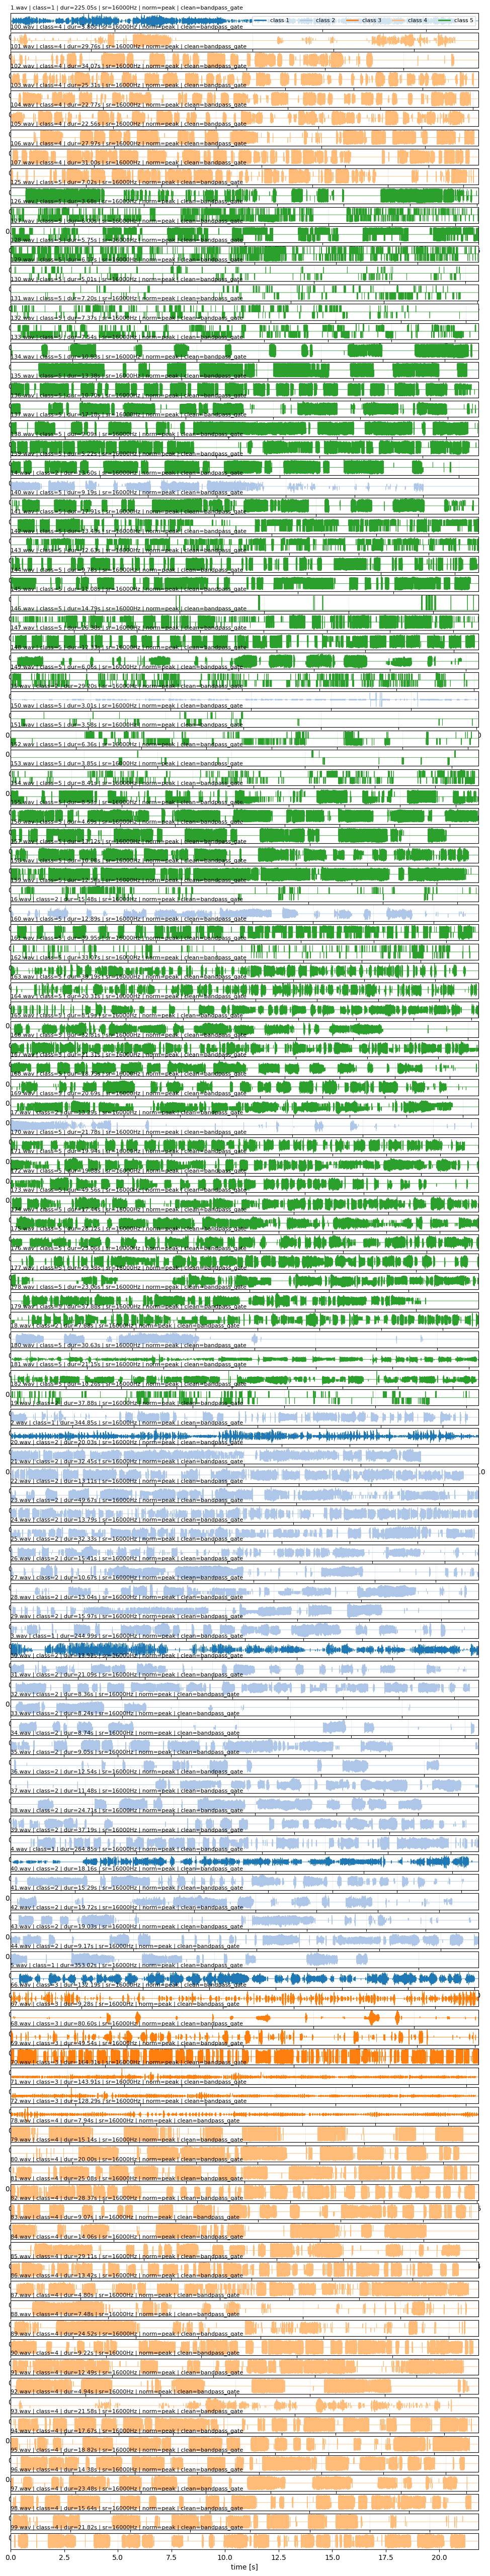

Saved 131 processed WAVs to:
C:\Users\herie\OneDrive - Fundacion Universidad de las Americas Puebla\Proyectos\En Proceso\Paralinguistic Speech Classification for Human Vocalizations\data\processed\Testing_data


In [7]:
# %pip install -U pandas matplotlib pydub

import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pydub import AudioSegment, effects as FX

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH    = "data/raw/training_label.csv"
AUDIO_DIR   = Path("data/raw/Training_data")
PATTERN     = "*.wav"
MAX_FILES   = None

# Processing
TARGET_SR   = 16_000          # None = keep original SR before export/plot
TARGET_SW   = 2               # bytes per sample in export (16-bit PCM)
MAKE_MONO   = True

# Normalization
NORMALIZE   = "peak"          # "peak", "rms", or None
TARGET_RMS  = 0.1             # used when NORMALIZE == "rms"
EPS         = 1e-12

# Noise cleaning
CLEAN_MODE  = "bandpass_gate" # "none", "bandpass", "gate", "bandpass_gate"
HPF_CUTOFF  = 100             # Hz
LPF_CUTOFF  = 6000            # Hz
GATE_K      = 1.5             # gate threshold = K * RMS

# Plotting
DOWNSAMPLE  = 4
row_h       = 0.5

# Export processed WAVs
OUTPUT_DIR  = Path(r"C:\Users\herie\OneDrive - Fundacion Universidad de las Americas Puebla\Proyectos\En Proceso\Paralinguistic Speech Classification for Human Vocalizations\data\processed\Testing_data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# HELPERS
# -----------------------------
def clean_segment(seg: AudioSegment) -> AudioSegment:
    if CLEAN_MODE in ("bandpass", "bandpass_gate"):
        if HPF_CUTOFF is not None: seg = FX.high_pass_filter(seg, HPF_CUTOFF)
        if LPF_CUTOFF is not None: seg = FX.low_pass_filter(seg, LPF_CUTOFF)
    return seg

def seg_to_np(seg: AudioSegment) -> tuple[np.ndarray, int]:
    """Return mono float32 in [-1,1) and sample_rate."""
    if MAKE_MONO and seg.channels != 1:
        seg = seg.set_channels(1)
    if TARGET_SR is not None and seg.frame_rate != TARGET_SR:
        seg = seg.set_frame_rate(TARGET_SR)
    if TARGET_SW is not None and seg.sample_width != TARGET_SW:
        seg = seg.set_sample_width(TARGET_SW)
    sr = seg.frame_rate
    sw = seg.sample_width
    arr = np.array(seg.get_array_of_samples())
    peak = float(1 << (8 * sw - 1))
    y = arr.astype(np.float32) / peak
    return y, sr

def normalize(y: np.ndarray, mode: str | None, target_rms: float) -> np.ndarray:
    if mode is None:
        return y
    if mode == "peak":
        m = float(np.max(np.abs(y)) + EPS)
        return y / m
    if mode == "rms":
        rms = float(np.sqrt(np.mean(y**2) + EPS))
        y2 = y * (target_rms / rms)
        return np.clip(y2, -1.0, 1.0)
    raise ValueError("NORMALIZE must be 'peak', 'rms', or None")

def gate(y: np.ndarray, k: float) -> np.ndarray:
    rms = float(np.sqrt(np.mean(y**2) + EPS))
    thr = k * rms
    y2 = y.copy()
    y2[np.abs(y2) < thr] = 0.0
    return y2

def np_to_segment(y: np.ndarray, sr: int) -> AudioSegment:
    """Pack float32 [-1,1) to 16-bit PCM mono AudioSegment."""
    y16 = np.clip(y * 32767.0, -32768, 32767).astype(np.int16)
    return AudioSegment(
        y16.tobytes(), frame_rate=int(sr), sample_width=2, channels=1
    )

# -----------------------------
# LOAD LABELS AND MATCH FILES
# -----------------------------
labels = pd.read_csv(CSV_PATH)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)

files = sorted(glob.glob(str(AUDIO_DIR / PATTERN)))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo", "clase"]], on="nombre_archivo", how="inner")
if MAX_FILES is not None:
    df = df.iloc[:MAX_FILES].copy()

n = len(df)
assert n > 0, "No matching labeled WAV files found."

# -----------------------------
# COLORS
# -----------------------------
classes = sorted(df["clase"].unique())
palette = plt.get_cmap("tab20").colors
color_map = {c: palette[i % len(palette)] for i, c in enumerate(classes)}

# -----------------------------
# PROCESS + EXPORT + PLOT
# -----------------------------
fig_h = max(3, row_h * n)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, fig_h), sharex=False)
if n == 1:
    axes = [axes]

legend_elems = []

for ax, (p, fname, cls) in zip(axes, df[["path", "nombre_archivo", "clase"]].itertuples(index=False, name=None)):
    # Load and clean
    seg = AudioSegment.from_file(p)
    seg = clean_segment(seg)

    # To numpy
    y, sr = seg_to_np(seg)

    # Gate and normalize
    if CLEAN_MODE in ("gate", "bandpass_gate"):
        y = gate(y, GATE_K)
    y = normalize(y, NORMALIZE, TARGET_RMS)

    # Export processed WAV
    seg_proc = np_to_segment(y, sr)
    out_path = OUTPUT_DIR / fname
    seg_proc.export(str(out_path), format="wav")

    # Plot
    y_plot = y[::DOWNSAMPLE] if (DOWNSAMPLE and DOWNSAMPLE > 1) else y
    sr_eff = sr / (DOWNSAMPLE if (DOWNSAMPLE and DOWNSAMPLE > 1) else 1)
    t = np.arange(len(y_plot)) / sr_eff if len(y_plot) else np.array([0.0])

    ax.plot(t, y_plot, linewidth=0.6, color=color_map[cls])
    ax.set_title(
        f"{fname} | class={cls} | dur={len(seg)/1000:.2f}s | sr={sr}Hz | norm={NORMALIZE} | clean={CLEAN_MODE}",
        fontsize=8, loc="left"
    )
    ax.set_yticks([]); ax.grid(True, alpha=0.2); ax.set_xlim(0, t[-1] if len(t) else 0)

# Correct legend call
legend_elems = [Line2D([0],[0], color=color_map[c], lw=2, label=f"class {c}") for c in classes]
axes[0].legend(handles=legend_elems, ncols=min(len(classes), 6), fontsize=8, loc="upper right", frameon=True)

axes[-1].set_xlabel("time [s]")
plt.tight_layout()
plt.show()

print(f"Saved {len(df)} processed WAVs to:\n{OUTPUT_DIR}")


In [ ]:
# %pip install -U pandas numpy scikit-learn pydub opensmile matplotlib joblib

from pathlib import Path
import glob, numpy as np, pandas as pd, joblib
from pydub import AudioSegment, effects as FX
import opensmile
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.calibration import CalibratedClassifierCV

# ==== CONFIG =================================================================
CSV_LABELS = Path("data/raw/training_label.csv")
RAW_DIR    = Path("data/raw/Training_data")
PROC_DIR   = Path(r"C:\Users\herie\OneDrive - Fundacion Universidad de las Americas Puebla\Proyectos\En Proceso\Paralinguistic Speech Classification for Human Vocalizations\data\processed\Testing_data")
PROC_DIR.mkdir(parents=True, exist_ok=True)

TARGET_SR  = 16_000
TARGET_SW  = 2            # 16-bit
MAKE_MONO  = True
HPF, LPF   = 150, 6000    # Hz
GATE_K     = 1.5          # τ = K·RMS
NORM_MODE  = "rms"        # "peak" or "rms"
TARGET_RMS = 0.1
TH_ABSTAIN = 0.55         # abstain if max prob < threshold

# Optional mapping if you know numeric→text classes:
# CLASS_MAP = {1:"healthy", 2:"asphyxia", 3:"hipoacusia", 4:"hiperbilirrubinemia", 5:"hipotiroidismo"}
CLASS_MAP = None

EPS = 1e-12

# ==== AUDIO HELPERS ==========================================================
def clean_seg(seg: AudioSegment) -> AudioSegment:
    if HPF: seg = FX.high_pass_filter(seg, HPF)
    if LPF: seg = FX.low_pass_filter(seg, LPF)
    return seg

def seg_to_float(seg: AudioSegment):
    if MAKE_MONO and seg.channels != 1: seg = seg.set_channels(1)
    if TARGET_SR   and seg.frame_rate != TARGET_SR: seg = seg.set_frame_rate(TARGET_SR)
    if TARGET_SW   and seg.sample_width != TARGET_SW: seg = seg.set_sample_width(TARGET_SW)
    sr = seg.frame_rate; sw = seg.sample_width
    arr = np.array(seg.get_array_of_samples())
    peak = float(1 << (8*sw - 1))  # 32768 for 16-bit
    y = arr.astype(np.float32) / peak
    return y, sr

def gate(y: np.ndarray, k: float) -> np.ndarray:
    rms = float(np.sqrt(np.mean(y**2) + EPS))
    thr = k * rms
    y2 = y.copy()
    y2[np.abs(y2) < thr] = 0.0
    return y2

def normalize(y: np.ndarray, mode: str, target_rms: float) -> np.ndarray:
    if mode == "peak":
        m = float(np.max(np.abs(y)) + EPS); return y / m
    rms = float(np.sqrt(np.mean(y**2) + EPS))
    y2  = y * (target_rms / rms)
    return np.clip(y2, -1.0, 1.0)

def float_to_seg(y: np.ndarray, sr: int) -> AudioSegment:
    y16 = np.clip(y * 32767.0, -32768, 32767).astype(np.int16)
    return AudioSegment(y16.tobytes(), frame_rate=int(sr), sample_width=2, channels=1)

# ==== LOAD LABELS & PROCESS AUDIO ===========================================
labels = pd.read_csv(CSV_LABELS)
labels["nombre_archivo"] = labels["nombre_archivo"].astype(str)
if CLASS_MAP: labels["clase_txt"] = labels["clase"].map(CLASS_MAP)

files = sorted(glob.glob(str(RAW_DIR/"*.wav")))
df = pd.DataFrame({"path": files, "nombre_archivo": [Path(f).name for f in files]})
df = df.merge(labels[["nombre_archivo","clase"]], on="nombre_archivo", how="inner")
assert len(df), "No labeled WAVs found."

proc_paths, y_numeric = [], []
for p, fname, cls in df[["path","nombre_archivo","clase"]].itertuples(index=False, name=None):
    seg = AudioSegment.from_file(p)
    seg = clean_seg(seg)
    y, sr = seg_to_float(seg)
    y = gate(y, GATE_K)
    y = normalize(y, NORM_MODE, TARGET_RMS)
    seg_out = float_to_seg(y, sr)
    outp = PROC_DIR / fname
    seg_out.export(str(outp), format="wav")
    proc_paths.append(str(outp))
    y_numeric.append(cls)

y = np.array(y_numeric)

# ==== FEATURE EXTRACTION (openSMILE) =========================================
# eGeMAPSv02 functionals (88-D) – robust low-dimensional baseline
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
feats = []
for wav in proc_paths:
    df_feat = smile.process_file(wav)  # 1-row DataFrame
    df_feat["file"] = Path(wav).name
    feats.append(df_feat.reset_index(drop=True))
Xdf = pd.concat(feats, axis=0, ignore_index=True).set_index("file")
X = Xdf.to_numpy()

# ==== MODEL: CALIBRATED LOGISTIC REGRESSION =================================
base = make_pipeline(StandardScaler(with_mean=True), LogisticRegression(max_iter=2000, n_jobs=None))
clf  = CalibratedClassifierCV(base, method="isotonic", cv=3)  # probability calibration

# CV predictions for evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(clf, X, y, cv=skf, method="predict_proba", n_jobs=-1)
pred  = probs.argmax(1)
f1m   = f1_score(y, pred, average="macro")
print("CV macro-F1:", f1m)
print(confusion_matrix(y, pred))
print(classification_report(y, pred, digits=3))

# Fit on all data and persist
clf.fit(X, y)
joblib.dump({"model": clf, "columns": Xdf.columns.tolist(), "class_map": CLASS_MAP}, "infantcry_eGeMAPS_logreg.joblib")

# ==== INFERENCE WRAPPER WITH ABSTAIN ========================================
def predict_wav(path_wav: str, model_bundle_path="infantcry_eGeMAPS_logreg.joblib", theta=TH_ABSTAIN):
    seg = AudioSegment.from_file(path_wav)
    seg = clean_seg(seg)
    y, sr = seg_to_float(seg)
    y = gate(y, GATE_K)
    y = normalize(y, NORM_MODE, TARGET_RMS)
    seg_out = float_to_seg(y, sr)  # optional: overwrite or keep temp
    tmp = Path(path_wav).with_suffix(".proc.wav"); seg_out.export(str(tmp), format="wav")

    mb = joblib.load(model_bundle_path)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    xf = smile.process_file(str(tmp))
    xf = xf[mb["columns"]].to_numpy()
    probs = mb["model"].predict_proba(xf)[0]
    k = probs.argmax(); p = probs[k]
    label = mb["class_map"].get(k+1, k+1) if mb["class_map"] else int(k+1)  # numeric→text if map provided
    return {"label": label if p >= theta else "abstain", "p_max": float(p), "probs": probs.tolist()}
